In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import time
from matplotlib import pyplot as plt

# Visualising the metadata of a raw edf file

In [4]:
file_path = Path(os.getcwd()).parent.parent / 'data/eegdata' / 'Subject12_1.edf'

raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

In [5]:
raw

<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>

In [6]:
raw.times

array([0.00000e+00, 2.00000e-03, 4.00000e-03, ..., 1.81994e+02,
       1.81996e+02, 1.81998e+02], shape=(91000,))

In [7]:
tmin = -0.2
tmax = 0.5 

sample_rate = int(raw.info['sfreq'])
event_spacing = sample_rate  # 1 event per second
n_samples = len(raw.times)

# Create events at regular intervals
events = np.array([
    [i, 0, 1] for i in range(0, n_samples, event_spacing)
    if i + int(tmax * sample_rate) < n_samples
])

In [8]:
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, 
                                    baseline=(None, 0), preload=True, verbose=False)

In [9]:
epochs

<Epochs | 181 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~10.2 MiB, data loaded,
 '1': 181>

In [10]:
raw.describe()

<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>
ch  name       type  unit        min         Q1     median         Q3        max
 0  EEG Fp1    EEG   µV       -46.07      -6.13       0.00       6.02      46.27
 1  EEG Fp2    EEG   µV       -65.87      -6.89      -0.00       6.96      52.10
 2  EEG F3     EEG   µV       -49.85      -6.06      -0.11       6.08      48.56
 3  EEG F4     EEG   µV       -48.40      -7.26      -0.00       7.34      44.59
 4  EEG F7     EEG   µV       -50.03      -5.81      -0.11       5.76      43.29
 5  EEG F8     EEG   µV       -44.28      -7.21       0.18       7.24      45.38
 6  EEG T3     EEG   µV       -46.16      -5.63      -0.05       5.59      45.08
 7  EEG T4     EEG   µV      -162.64     -10.25      -0.19       9.69     139.24
 8  EEG C3     EEG   µV       -52.18      -6.31      -0.13       6.14      48.54
 9  EEG C4     EEG   µV       -58.03      -7.29      -0.24       7.12      54.64
10  EEG T5     EEG   µV       -48.77

In [11]:
raw.ch_names

['EEG Fp1',
 'EEG Fp2',
 'EEG F3',
 'EEG F4',
 'EEG F7',
 'EEG F8',
 'EEG T3',
 'EEG T4',
 'EEG C3',
 'EEG C4',
 'EEG T5',
 'EEG T6',
 'EEG P3',
 'EEG P4',
 'EEG O1',
 'EEG O2',
 'EEG Fz',
 'EEG Cz',
 'EEG Pz',
 'EEG A2-A1',
 'ECG ECG']

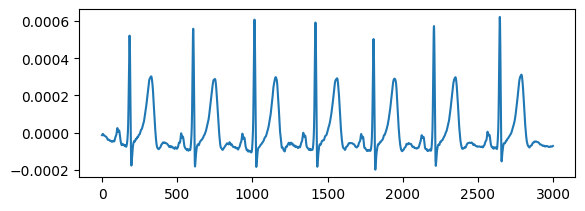

In [12]:
raw.ch_names
plotraw = raw.copy()
# plotraw.pick('EEG O1').plot()
# mne.preprocessing.find_ecg_events(raw)
plt.subplot(2, 1, 1)
plt.plot(plotraw.pick('ECG ECG').get_data([0])[0][:3000].flatten())
plt.show()

In [27]:
modraw = raw.copy()
modraw.set_channel_types({'ECG ECG': 'ecg'})

<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>

In [28]:
modraw.describe()

<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>
ch  name       type  unit        min         Q1     median         Q3        max
 0  EEG Fp1    EEG   µV       -46.07      -6.13       0.00       6.02      46.27
 1  EEG Fp2    EEG   µV       -65.87      -6.89      -0.00       6.96      52.10
 2  EEG F3     EEG   µV       -49.85      -6.06      -0.11       6.08      48.56
 3  EEG F4     EEG   µV       -48.40      -7.26      -0.00       7.34      44.59
 4  EEG F7     EEG   µV       -50.03      -5.81      -0.11       5.76      43.29
 5  EEG F8     EEG   µV       -44.28      -7.21       0.18       7.24      45.38
 6  EEG T3     EEG   µV       -46.16      -5.63      -0.05       5.59      45.08
 7  EEG T4     EEG   µV      -162.64     -10.25      -0.19       9.69     139.24
 8  EEG C3     EEG   µV       -52.18      -6.31      -0.13       6.14      48.54
 9  EEG C4     EEG   µV       -58.03      -7.29      -0.24       7.12      54.64
10  EEG T5     EEG   µV       -48.77

# Applying some preprocessing

In [29]:
ica = mne.preprocessing.ICA(
    n_components=15,
    random_state=42,
    method='fastica'
)

# Fit ICA on the data
ica.fit(modraw)

Fitting ICA to data using 20 channels (please be patient, this may take a while)
Selecting by number: 15 components


C:\Users\Audit\AppData\Local\Temp\ipykernel_97232\2082886183.py:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(modraw)


Fitting ICA took 0.7s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,36 iterations on raw data (91000 samples)
ICA components,15
Available PCA components,20
Channel types,eeg
ICA components marked for exclusion,—


In [36]:
ica.apply(modraw)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 20 PCA components


<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>

In [37]:
components = ica.get_components()

In [38]:
components.shape

(20, 15)

In [39]:
# Applying bandpass filter
modraw.filter(l_freq=0.5, h_freq=40.0, picks='eeg', method='fir', phase='zero')

# Applying notch filter to remove power line noise

modraw.notch_filter(freqs=60, picks='eeg')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>

In [20]:
csv_path = Path(os.getcwd()).parent.parent / 'data/eegdata' / 'subject-info.csv'

metadata_df = pd.read_csv(csv_path)

In [43]:
metadata_df

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0
5,Subject05,16,F,2010,20.71,1
6,Subject06,18,M,2011,4.35,0
7,Subject07,18,F,2012,13.38,1
8,Subject08,26,M,2011,18.24,1
9,Subject09,16,F,2010,7.00,0


In [22]:
metadata_df['Count quality'].value_counts()

Count quality
1    26
0    10
Name: count, dtype: int64

In [33]:
file_path = Path(os.getcwd()).parent.parent / 'data/eegdata'
eeg_filepath_object = file_path.glob('*.edf')
eeg_files_paths = [i for i in eeg_filepath_object]

In [ ]:
# read raw eeg files, preprocess them and save the resulting mne obj to a dictionary

processed_eeg_extract = {}

for file in eeg_files_paths:
    
    raw = mne.io.read_raw_edf(file, preload=True, verbose=False)